In [1]:
using Petri
using MacroTools
import MacroTools: postwalk, striplines
using ModelingToolkit
import ModelingToolkit: Constant
import Base: ==, ∈, show, ^
using Catlab.Doctrines
import Catlab.Doctrines: ⊗, compose, otimes
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
import Catlab.Graphics.Graphviz: Graph, Edge
using SemanticModels
using SemanticModels.ModelTools.WiringDiagrams
using SemanticModels.ModelTools.PetriModels

In [2]:
using LabelledArrays
using OrdinaryDiffEq
import OrdinaryDiffEq: solve
using Plots
Petri.N(s) = 1 #sum(s[1:end-3])

In [3]:
using SemanticModels.ModelTools.OpenPetris
import Petri: NullPetri, Graph
import SemanticModels.ModelTools.OpenModels: OpenModel
import SemanticModels.ModelTools: model

In [4]:

⊗(f::OpenModel,g::OpenModel) = otimes(f,g)
⊚(f::OpenModel,g::OpenModel) = compose(f,g)

^(x::Doctrines.FreeSymmetricMonoidalCategory.Ob{:generator}, n::Int) = foldl(⊗, x for i in 1:n)
^(f::Doctrines.FreeSymmetricMonoidalCategory.Hom{:id}, n::Int64) = foldl(⊗, f for i in 1:n)

conj(a::OpenModel, b::OpenModel) = compose(b,a,b)
conj(a, b) = compose(b,a,b) 
""" op(f::Model)

return the opposite model you get by reversing the direction of all the transitions
"""
op(f::Model) = Model(f.S, map(f.Δ) do t reverse(t) end)

op(f::OpenModel) = OpenModel(f.dom, op(f.model), f.codom)
wd(ex) = to_wiring_diagram(ex)

function compile(expr::Doctrines.FreeSymmetricMonoidalCategory.Hom{:compose}, ctx::Dict)
#     println("∘")
    compose(compile.(expr.args, (ctx,)))
end
function compile(expr::Doctrines.FreeSymmetricMonoidalCategory.Hom{:otimes}, ctx::Dict)
#     println("⊗")
    otimes(compile.(expr.args, (ctx,)))
end
function compile(expr, ctx::Dict)
    # @show expr
    return ctx[expr]
end


compile (generic function with 3 methods)

In [5]:
function show(io::IO, z::Petri.Model)
    X, Y = z.S, z.Δ
    compact = get(io, :compact, true)
    if compact
        x,y = length(X), length(Y)
        print(io,"Model(∣S∣=$x,∣Δ∣=$y)")
    else
        print(io,"Model(S=$X, Δ=$Y)")
    end
end
function show(io::IO, z::OpenModel)
    X,Y = z.dom, z.codom
    compact = get(io, :compact, true)
    if compact
        x,y = length(X), length(Y)
        print(io,"OpenModel:$x→$y with ")
        show(io,z.model)
    else
        print(io,"Domain: $X\nCodomain: $Y\nModel: ")
        show(io, z.model)
    end
end


function debug_show(io::IO, f::Model)
    X,Y = f.S, f.Δ
    print(io,"Model(S=$X, Δ=")
    if length(Y) == 0
        print("[])")
    else
        for (i,t) in enumerate(Y)
            if i == 1
                print(io, "[")
                print(io, "$(t[1])→$(t[2]),")
            end
            if 1 < i < length(Y)
                print(io, " $(t[1])→$(t[2]),")
            end
            if i == length(Y)
                print(io, " $(t[1])→$(t[2])])\n")
            end
        end
    end
end

varlookup(x) = begin
    string(OpenPetris.X[x].op.name)
end

varlookup(M::Petri.Model) = Petri.Model(varlookup.(M.S), M.Δ)
varlookup(M::PetriModel) = PetriModel(varlookup(M.model))
#varlookup(f::OpenModel) = OpenModel(varlookup.(f.dom), varlookup(f.model), varlookup(f.codom))

function Graph1(f::OpenModel)
    g = Petri.Graph(f.model.model)
    A, M, B = f.dom, f.model.model, f.codom
    stmts_dom = map(enumerate(A)) do (i,a)
        m = try
            M.S[i]
        catch
            a
        end
        
        Edge(["I$i", "$m"], Attributes(:style=>"dashed"))
    end
    stmts_codom = map(enumerate(B)) do (i,a)
        m = try
            M.S[i]
        catch
            a
        end
        Edge(["$m", "O$i"], Attributes(:style=>"dashed"))
    end
    append!(g.stmts, append!(stmts_dom, stmts_codom))
    return g
end

debug_show(io::IO, f::OpenModel) = begin
    X,Y = f.dom, f.codom
    print(io,"Domain: $X\nCodomain: $Y\nModel: ")
    debug_show(io, f.model)
    println(io, "\n")
    M = f.model
    @show M
    f′ = OpenModel(varlookup.(f.dom), varlookup(M), varlookup.(f.codom)) 
    @show f′
    g = Graph1(f′)
end
            
debug_show(f::OpenModel) = begin
    debug_show(stdout, f)
end

debug_show(io::IO, f::PetriModel) = debug_show(io, f.model)
debug_show(f::PetriModel) = debug_show(stdout, f.model)

function debug_show(io::IO, f::OpenModel, fname::String)
    g = debug_show(io, f)
    output = run_graphviz(g, prog="dot", format="svg")
    write(fname, output)
    return g
end

debug_show(f::OpenModel, fname::String) = debug_show(stdout, f, fname)
odeexpr(m::OpenModel) = symbolic_symplify(Petri.odefunc(m.model.model, :state)) |> striplines


odeexpr (generic function with 1 method)

In [6]:
Base.show(io::IO, mime::MIME"text/html", f::OpenModel) = begin 
    g = debug_show(io, f)
    show(io, mime, g)
    g
end
import Base.display
display(f::OpenModel) = debug_show(f)
display(f::WiringDiagram) = to_graphviz(f, orientation=LeftToRight)
pad(f::WiringDiagram, v::Vector) = vcat(v, ["" for i in 1:length(wires(f))-length(v)])
display(f::WiringDiagram, labels::Vector) = SemanticModels.ModelTools.WiringDiagrams.label!(display(f), string.(pad(f, labels)))

display (generic function with 33 methods)

In [7]:
Base.Filesystem.mkpath("img")
X = OpenPetris.X;

# Semantic Modeling Software Demo

**Agenda**

| #  | Layer | Type | Examples |
|---|-------|------|----------|
|1 | Structured | Petri Nets| Epidemiological Models (SIR, SIIR)| 
|2 | Abstract | Wiring Diagrams| Ecological Models |
|3 | Executable | ODEs | Initial Value Problems |



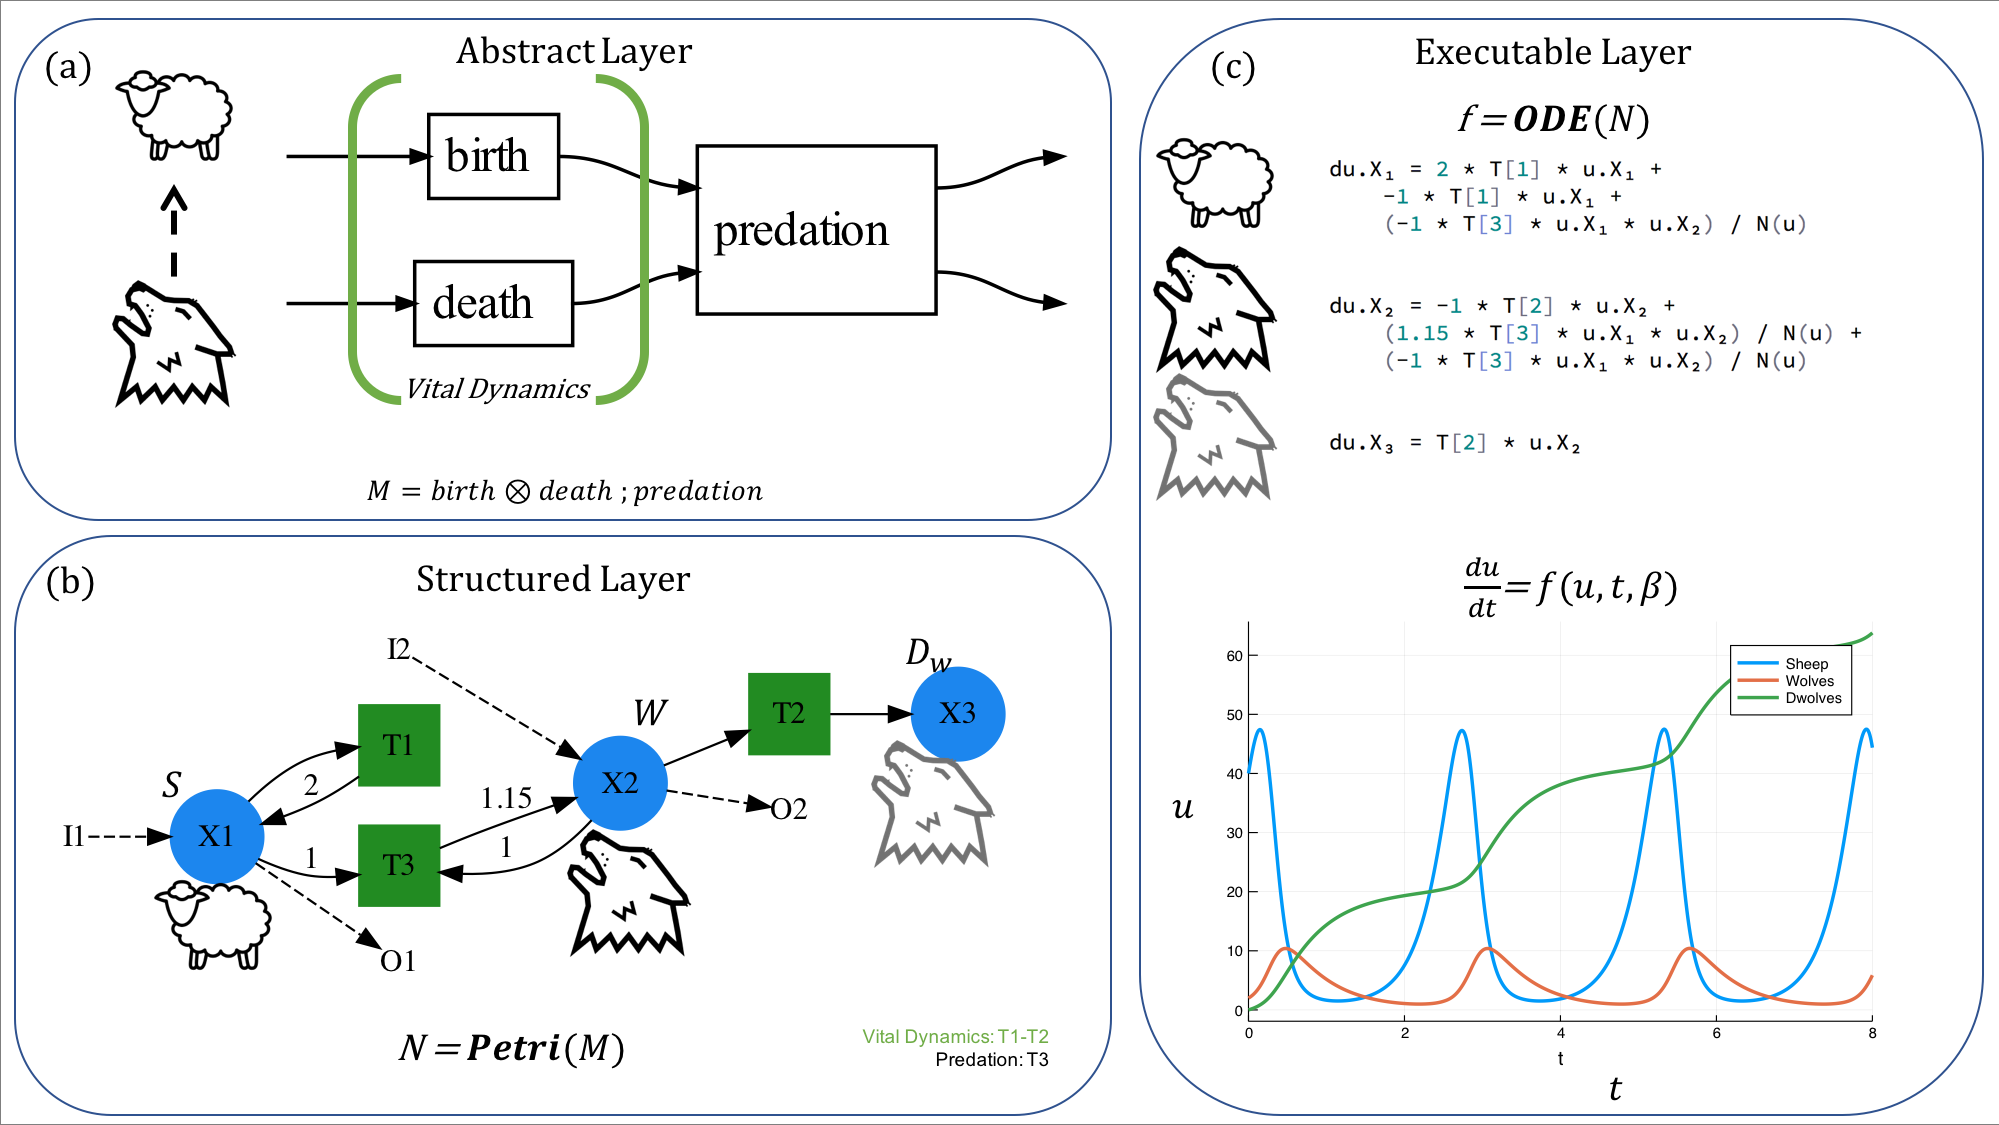


# Primitives of Petri Net Modeling Framework

We start by defining some primitive models. First is the spontaneous reaction. It takes $X_1\rightarrow X_2$

In [8]:
OpenModel([1,2], model(PetriModel, Petri.Model([1,2], [(X[1], X[2])])), [1,2])


M = PetriModel(Model(∣S∣=2,∣Δ∣=1))
f′ = 

OpenModel:2→2 with PetriModel(Model(∣S∣=2,∣Δ∣=1))

OpenModel:2→2 with PetriModel(Model(∣S∣=2,∣Δ∣=1))


In [9]:
using SemanticModels.ModelTools.CategoryTheory

In [10]:
f2 = FinSetMorph(1:2, [1,2])
Decorated(f2, model(PetriModel, Petri.Model([1,2], [(X[1],X[2])])))

Decorated{FinSetMorph{UnitRange{Int64},Array{Int64,1}}}(FinSetMorph{UnitRange{Int64},Array{Int64,1}}(1:2, [1, 2]), SemanticModels.ModelTools.AbstractModel[PetriModel(Model(∣S∣=2,∣Δ∣=1))])

In [11]:
println("\nSpontaneous reaction: spontaneous = X₁→X₂")
spontaneous = OpenModel([1,2],
    model(PetriModel, Petri.Model([1,2], [(X[1],X[2])])),
    [1,2])
display(spontaneous.model)

PetriModel(Model(∣S∣=2,∣Δ∣=1))


Spontaneous reaction: spontaneous = X₁→X₂


### Parallel reaction: 

We can also combine models by stacking them one on top of the other independently
$parallel = spontaneous \otimes spontaneous = X_1\rightarrow X_2, X_3\rightarrow X_4$

In [12]:
println("\nParallel reaction: parallel = spontaneous ⊗ spontaneous = X₁→X₂, X₃→X₄")
parallel = OpenPetris.otimes(spontaneous, spontaneous)
display(parallel.model.model)

Model(∣S∣=4,∣Δ∣=2)


Parallel reaction: parallel = spontaneous ⊗ spontaneous = X₁→X₂, X₃→X₄


### Model Composition

We can compose models by wiring the inputs of one to the outputs of another. We define most of our primitives to have all variables as inputs and outputs.

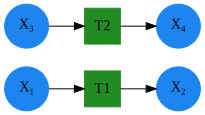

In [13]:
Graph(varlookup(parallel.model).model)

In [14]:
using SemanticModels.ModelTools.PetriModels

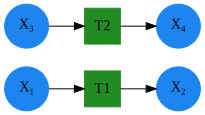

In [15]:
Graph(varlookup(parallel.model).model)

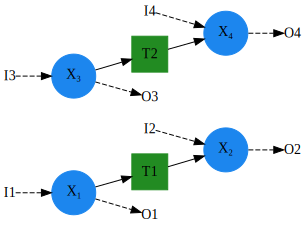

In [16]:
varlookup.(parallel.codom)
varlookup(parallel.model)
m1 = OpenModel(varlookup.(parallel.dom), varlookup(parallel.model), varlookup.(parallel.codom))
Graph1(m1)
#parallel

In [17]:
display(compose(spontaneous,spontaneous));

Domain: [1, 2]
Codomain: [1, 2]
Model: Model(S=[1, 2], Δ=[X₁()→X₂(), X₁()→X₂()])


M = PetriModel(Model(∣S∣=2,∣Δ∣=2))
f′ = OpenModel:2→2 with PetriModel(Model(∣S∣=2,∣Δ∣=2))


### Introducing new variables

In order to introduce new variables, you can use the $I$ = `eye(1)` model with represents the identity process on 1 variable. This pattern of $a\otimes I; I \otimes b$ will be very important. We will use the $f;g$ operator to denote composition of $f$ followed by $g$ because the mathematical symbol $f\circ g$ is already defined as $g(f)$ which is backwards. 

In [18]:
display(eye(1).model)

PetriModel(Model(∣S∣=1,∣Δ∣=0))

In [19]:
eye(1).model |> typeof

PetriModel

In [20]:
display((spontaneous ⊗ eye(1), eye(1) ⊗ spontaneous))

(OpenModel:3→3 with PetriModel(Model(∣S∣=3,∣Δ∣=1)), OpenModel:3→3 with PetriModel(Model(∣S∣=3,∣Δ∣=1)))

### Adding new primitives

Any Petri Net can be converted into a primitive building block by designating a set of variables to be the input (domain) and output (codomain).


Infection reaction infect = X₁+X₂→ 2X₂
Domain: [1, 2]
Codomain: [1, 2]
Model: Model(S=[1, 2], Δ=[X₁() + X₂()→2 * X₂(), X₁() + X₂()→2 * X₂()])


M = PetriModel(Model(∣S∣=2,∣Δ∣=1))
f′ = OpenModel:2→2 with PetriModel(Model(∣S∣=2,∣Δ∣=1))


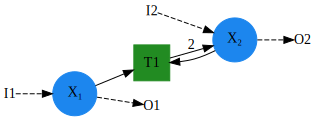

In [21]:
println("\nInfection reaction infect = X₁+X₂→ 2X₂")
infect = OpenModel([1,2], PetriModel(Petri.Model([1,2], [(X[1]+X[2], 2*X[2])])), [1,2])
display(infect)

### Swapping Arguments

You can reverse the inputs of a model using a special model called $\sigma$. Since all permutations can be factored into swaps (see bubble sort), we can use $\sigma$ to make arbitrary permutations. 

Domain: [1, 2]
Codomain: [2, 1]
Model: Model(S=[1, 2], Δ=[])

M = PetriModel(Model(∣S∣=2,∣Δ∣=0))
f′ = OpenModel:2→2 with PetriModel(Model(∣S∣=2,∣Δ∣=0))


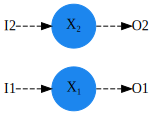

In [22]:
σ() = OpenModel([1,2], PetriModel(NullPetri(2)), [2,1])
display(σ())

Domain: [1, 2]
Codomain: [2, 1]
Model: Model(S=[1, 2], Δ=[X₂()→X₁(), X₂()→X₁()])


M = PetriModel(Model(∣S∣=2,∣Δ∣=1))
f′ = OpenModel:2→2 with PetriModel(Model(∣S∣=2,∣Δ∣=1))


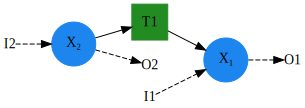

In [23]:
spontaneousdag = compose(σ(), spontaneous)
display(spontaneousdag)

## Model Execution

We now have everything we need to make an SIS model. The `odeexpr` function converts a petri net into a program for evaluating the corresponding differential equations.

odeexpr(sis) = quote
    ##state#371(du, u, T, t) = begin
            begin
                du.X₁ = (-1 * T[1] * u.X₁ * u.X₂) / N(u) + T[2] * u.X₂
                du.X₂ = (2 * T[1] * u.X₁ * u.X₂) / N(u) + (-1 * T[1] * u.X₁ * u.X₂) / N(u) + -1 * T[2] * u.X₂
            end
        end
end
Domain: [1, 2]
Codomain: [2, 1]
Model: Model(S=[1, 2], Δ=[X₁() + X₂()→2 * X₂(), X₂()→X₁()])


M = PetriModel(Model(∣S∣=2,∣Δ∣=2))
f′ = OpenModel:2→2 with PetriModel(Model(∣S∣=2,∣Δ∣=2))


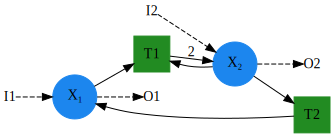

In [24]:
sis = compose(infect, spontaneousdag)
@show odeexpr(sis)
display(sis)

In [25]:
sis.model.model.S

2-element Array{Int64,1}:
 1
 2

In [26]:
sis.model.model.Δ

2-element Array{Tuple{Operation,Operation},1}:
 (X₁() + X₂(), 2 * X₂())
 (X₂(), X₁())           

In [27]:
Petri.fluxes(sis.model.model)

2-element Array{Expr,1}:
 :(du.X₁ = (-1 / 1) * ((param[1] * (state.X₁ * state.X₂)) / N(state)) + 1 * (param[2] * state.X₂))                                                             
 :(du.X₂ = 2 * ((param[1] * (state.X₁ * state.X₂)) / N(state)) + (-1 / 1) * ((param[1] * (state.X₁ * state.X₂)) / N(state)) + (-1 / 1) * (param[2] * state.X₂))

### SIR Model

The SIR model can be built from these primitives too. We use the $a\otimes I; I \otimes b$ pattern to introduce a third variable $X_3=R$

odeexpr(sir) = quote
    ##state#372(du, u, T, t) = begin
            begin
                du.X₁ = (-1 * T[1] * u.X₁ * u.X₂) / N(u)
                du.X₃ = T[2] * u.X₂
                du.X₂ = (2 * T[1] * u.X₁ * u.X₂) / N(u) + (-1 * T[1] * u.X₁ * u.X₂) / N(u) + -1 * T[2] * u.X₂
            end
        end
end
Domain: [1, 2, 3]
Codomain: [1, 2, 3]
Model: Model(S=[1, 2, 3], Δ=[X₁() + X₂()→2 * X₂(), X₂()→X₃()])


M = PetriModel(Model(∣S∣=3,∣Δ∣=2))
f′ = OpenModel:3→3 with PetriModel(Model(∣S∣=3,∣Δ∣=2))


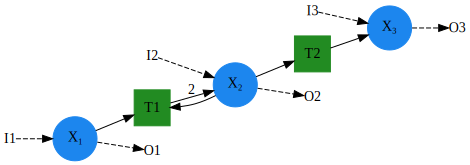

In [28]:
sir = compose(infect⊗eye(1), eye(1)⊗spontaneous)
@show odeexpr(sir)
display(sir)

### A modeling language

Every model you build is a new term that you can use to make more complex models. For example $sir\otimes sir$ is two uncoupled $SIR$ diseases.

Domain: [1, 2, 3, 4, 5, 6]
Codomain: [1, 2, 3, 4, 5, 6]
Model: Model(S=[1, 2, 3, 4, 5, 6], Δ=[X₁() + X₂()→2 * X₂(), X₂()→X₃(), X₄() + X₅()→2 * X₅(), X₅()→X₆()])


M = PetriModel(Model(∣S∣=6,∣Δ∣=4))
f′ = OpenModel:6→6 with PetriModel(Model(∣S∣=6,∣Δ∣=4))


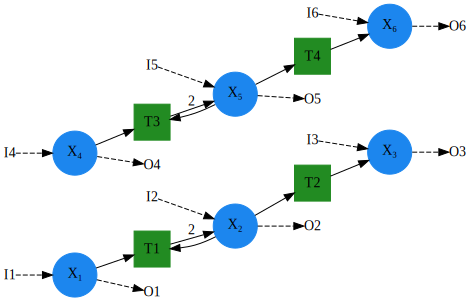

In [29]:
display(sir⊗sir)

### Merging States

But real world systems don't combine independently all too often, we need a way to couple things. The family of models $m_{i,j}$ combine the $i$th and $j$th input states into one input state, by taking the disjoint union of their transitions. We can use these models to combine systems by "state sharing". This will allow us to build a SIIR model where two strains of a disease compete for susceptible people.


Parallel Infections reactions infect ⊗ infect = X₁+X₂→ 2X₂ && X₃ +X₄ → 2X₄
Domain: [1, 3]
Codomain: [2, 4]
Model: Model(S=[1, 2, 3, 4], Δ=[X₁() + X₂()→2 * X₂(), X₃() + X₄()→2 * X₄()])


M = PetriModel(Model(∣S∣=4,∣Δ∣=2))
f′ = OpenModel:2→2 with PetriModel(Model(∣S∣=4,∣Δ∣=2))


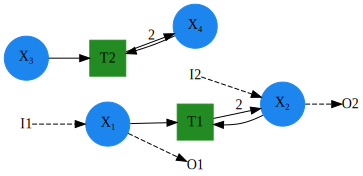

In [30]:
m₁₂ = OpenModel([1], model(PetriModel, NullPetri(1)), [1,1])
println("\nParallel Infections reactions infect ⊗ infect = X₁+X₂→ 2X₂ && X₃ +X₄ → 2X₄")
# set the codomains to be narrower to help with composition
infect′ = OpenModel([1], infect.model, [2])
spontaneous′ = OpenModel([1], spontaneous.model, [2])
parinfect′ = infect′ ⊗ infect′
display(parinfect′)

Domain: [1]
Codomain: [1, 1]
Model: Model(S=[1], Δ=[])

M = PetriModel(Model(∣S∣=1,∣Δ∣=0))
f′ = OpenModel:1→2 with PetriModel(Model(∣S∣=1,∣Δ∣=0))


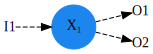

In [31]:
display(m₁₂)

Domain: [1]
Codomain: [2, 3]
Model: Model(S=[1, 2, 3], Δ=[X₁() + X₂()→2 * X₂(), X₁() + X₃()→2 * X₃()])


M = PetriModel(Model(∣S∣=3,∣Δ∣=2))
f′ = OpenModel:1→2 with PetriModel(Model(∣S∣=3,∣Δ∣=2))


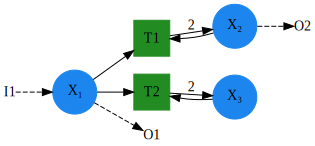

In [32]:
display(compose(m₁₂, parinfect′))

Domain: [1, 2]
Codomain: [3]
Model: Model(S=[1, 2, 3], Δ=[X₁()→X₃(), X₂()→X₃()])


M = PetriModel(Model(∣S∣=3,∣Δ∣=2))
f′ = OpenModel:2→1 with PetriModel(Model(∣S∣=3,∣Δ∣=2))


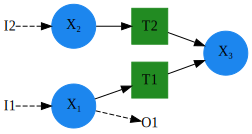

In [33]:
mutrec = OpenModel([1,2], model(PetriModel, Model([1,2,3], [(X[1],X[3]), (X[2], X[3])])), [3])
display(mutrec)

Domain: [1]
Codomain: [4]
Model: Model(S=[1, 2, 3, 4], Δ=[X₁() + X₂()→2 * X₂(), X₁() + X₃()→2 * X₃(), X₂()→X₄(), X₃()→X₄()])


M = PetriModel(Model(∣S∣=4,∣Δ∣=4))
f′ = OpenModel:1→1 with PetriModel(Model(∣S∣=4,∣Δ∣=4))


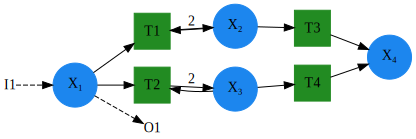

In [34]:
siir = compose(m₁₂, parinfect′, mutrec)
display(siir)

In [35]:
odeexpr(siir)

quote
    ##state#373(du, u, T, t) = begin
            begin
                du.X₁ = (-1 * T[1] * u.X₁ * u.X₂) / N(u) + (-1 * T[2] * u.X₁ * u.X₃) / N(u)
                du.X₃ = (2 * T[2] * u.X₁ * u.X₃) / N(u) + (-1 * T[2] * u.X₁ * u.X₃) / N(u) + -1 * T[4] * u.X₃
                du.X₄ = T[3] * u.X₂ + T[4] * u.X₃
                du.X₂ = (2 * T[1] * u.X₁ * u.X₂) / N(u) + (-1 * T[1] * u.X₁ * u.X₂) / N(u) + -1 * T[3] * u.X₂
            end
        end
end

An interesting lemma is that if you have an OpenModel $f$ and a pair of states $x,y$ with no common transition, such that $x\notin dom(f)$ and $y \notin codom(f)$ there is no OpenModel $g$ such that $f;g$ (or $g;f$) has a transition between $x,y$. 

This is why we prefer to define primitives such that $dom(f) = codom(f) = States(f)$ when convenient.

# Abstract Knowledge Layer

The Petri Net layer is useful because it contains a mathematically rigorous formulation of the scientific system under study that can be used to generate simulations at the executable layer. However, they do not cont any capacity for abstraction or encapsulation, which are necessary for human-level intelligent reasoning.

We now introduce Wiring Diagrams through some motivating examples from Ecology.

## Ecological Models 

In [36]:
println("\nCreating food web processes birth, death, predation")
birth   = model(PetriModel, Model([1], [(X[1], 2X[1])]))
death   = model(PetriModel, Model([1, 2], [(X[1], X[2])]))
pred(α,β,γ) = model(PetriModel, Model([1, 2], [(α*X[1] + β*X[2], γ*X[2])]))

b = OpenModel([1], birth, [1])
d = OpenModel([1], death, [1])
p(α, β, γ) = OpenModel([1,2], pred(α, β, γ), [1,2])
println("\nCreating food web processes σ, predation†")

pdag(α,β,γ) = OpenModel([1,2], model(PetriModel, Model([1, 2], [(α*X[2] + β*X[1], γ*X[1])])), [1,2])

# Catlab expressions for our variables
Xob = Ob(FreeSymmetricMonoidalCategory, :X)
idₓ = id(Xob)
σh = braid(Xob, Xob)
bh = Hom(:birth, Xob,Xob)
dh = Hom(:death, Xob, Xob)
ph = Hom(:predation, Xob^2, Xob^2)
pdagh = Hom(Symbol("p⋆"), Xob^2, Xob^2)
lookuptable = Dict( idₓ=>eye(1), σh=>σ(), bh=>b, dh=>d, ph=>p(1,1,1.15))
set_primitive!(ctx::Dict, hom, f::OpenModel) = begin
    ctx[hom] = f
    return ctx
end
set_primitive(hom, f::OpenModel) = set_primitive!(lookuptable, hom, f)
compile(x) = compile(x, lookuptable)


Creating food web processes birth, death, predation

Creating food web processes σ, predation†


compile (generic function with 4 methods)

## The Lotka Volterra Model

A simple model of predator-prey dynamics that is widely used in ecology is the Lotka-Volterra model. The prey species grows exponentially, and is eaten by a predator species that suffers from contant probability of death (exponential decay). This model has periodic solutions that are non-trigonometric.




### Wiring Diagrams

In the following diagram of the Lotka-Volterra System, wires represent species and boxes represent interactions. The wires that go into a box are the domain and the wires that go out are the codom. You read it from left to right.

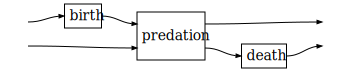

In [37]:
bd = b⊗d
lvh = compose(bh⊗idₓ, ph, idₓ⊗dh)
drawhom(lvh, "img/lv_wd")

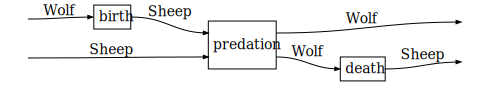

In [42]:
display(wd(lvh), [:Wolf, :Sheep, :Sheep, :Wolf, :Wolf,:Sheep])

### Compiling a Wiring Diagram

The wiring diagram approach allows you to specify a model by connecting up a circuit of component models. We can convert the diagramatic representation into a Petri Net with `compile`. Note that the state $X_3$ is neither an input nor an output to the model. This implies that no others species can interact with the deceased wolves (ie. vultures are forbidden).

In [43]:
lvh

compose(otimes(birth,id(X)),predation,otimes(id(X),death))

OpenModel:2→2 with PetriModel(Model(∣S∣=3,∣Δ∣=3))
Domain: [1, 2]
Codomain: [1, 2]
Model: Model(S=[1, 2, 3], Δ=[X₁()→2 * X₁(), 1 * X₁() + 1 * X₂()→1.15 * X₂(), X₂()→X₃()])


M = PetriModel(Model(∣S∣=3,∣Δ∣=3))
f′ = OpenModel:2→2 with PetriModel(Model(∣S∣=3,∣Δ∣=3))


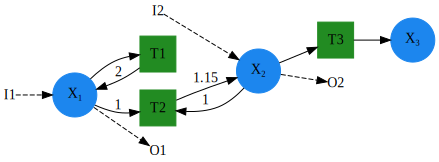

In [44]:
lv = compile(lvh)
println(lv)
debug_show(lv,"img/lv.svg")

### Three Layers

At this point we can see all three layers of the Lotka-Volterra model. Wiring Diagram -> Petri Net -> ODEs

In [45]:
@show odeexpr(lv)
f = Petri.mk_function(lv.model.model)

odeexpr(lv) = quote
    ##state#374(du, u, T, t) = begin
            begin
                du.X₁ = 2 * T[1] * u.X₁ + -1 * T[1] * u.X₁ + (-1 * T[2] * u.X₁ * u.X₂) / N(u)
                du.X₃ = T[3] * u.X₂
                du.X₂ = (1.15 * T[2] * u.X₁ * u.X₂) / N(u) + (-1 * T[2] * u.X₁ * u.X₂) / N(u) + -1 * T[3] * u.X₂
            end
        end
end


#65 (generic function with 1 method)

sol[end] = 3-element LArray{Float64,1,Array{Float64,1},(:X₁, :X₂, :X₃)}:
 :X₁ => 44.36070557482844 
 :X₂ => 5.86504646968141  
 :X₃ => 63.781311063047546


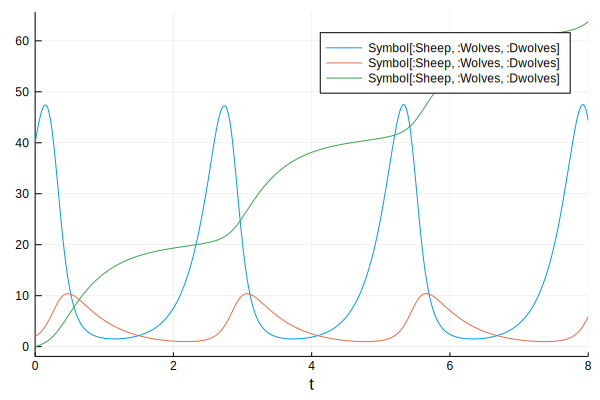

In [46]:
νS = 4
ηS = 1.0
δW = 2.0
params = [νS, ηS, δW]
u0 = @LArray [40,2,0.0] (:X₁, :X₂, :X₃)
prob = ODEProblem(f,u0,(0.0,8.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]

varnames = [:Sheep, :Wolves, :Dwolves]

plt = plot(sol, vars =1:length(varnames), labels=varnames)

savefig(plt, "img/lv_sol.pdf")
plt

### Putting it all together

The Lotka-Volterra Model is a classic example of dynamical systems in mathematical ecology. We can view it at three layers of knowledge.

1. Abstract: a wiring diagram with the interaction structure, we have no mathematical or computational knowledge about the dynamics.
2. Structured: a Petri Net describing reaction kinetics dynamics
3. Executable: a program for solving the system of ODEs implied by the structured layer



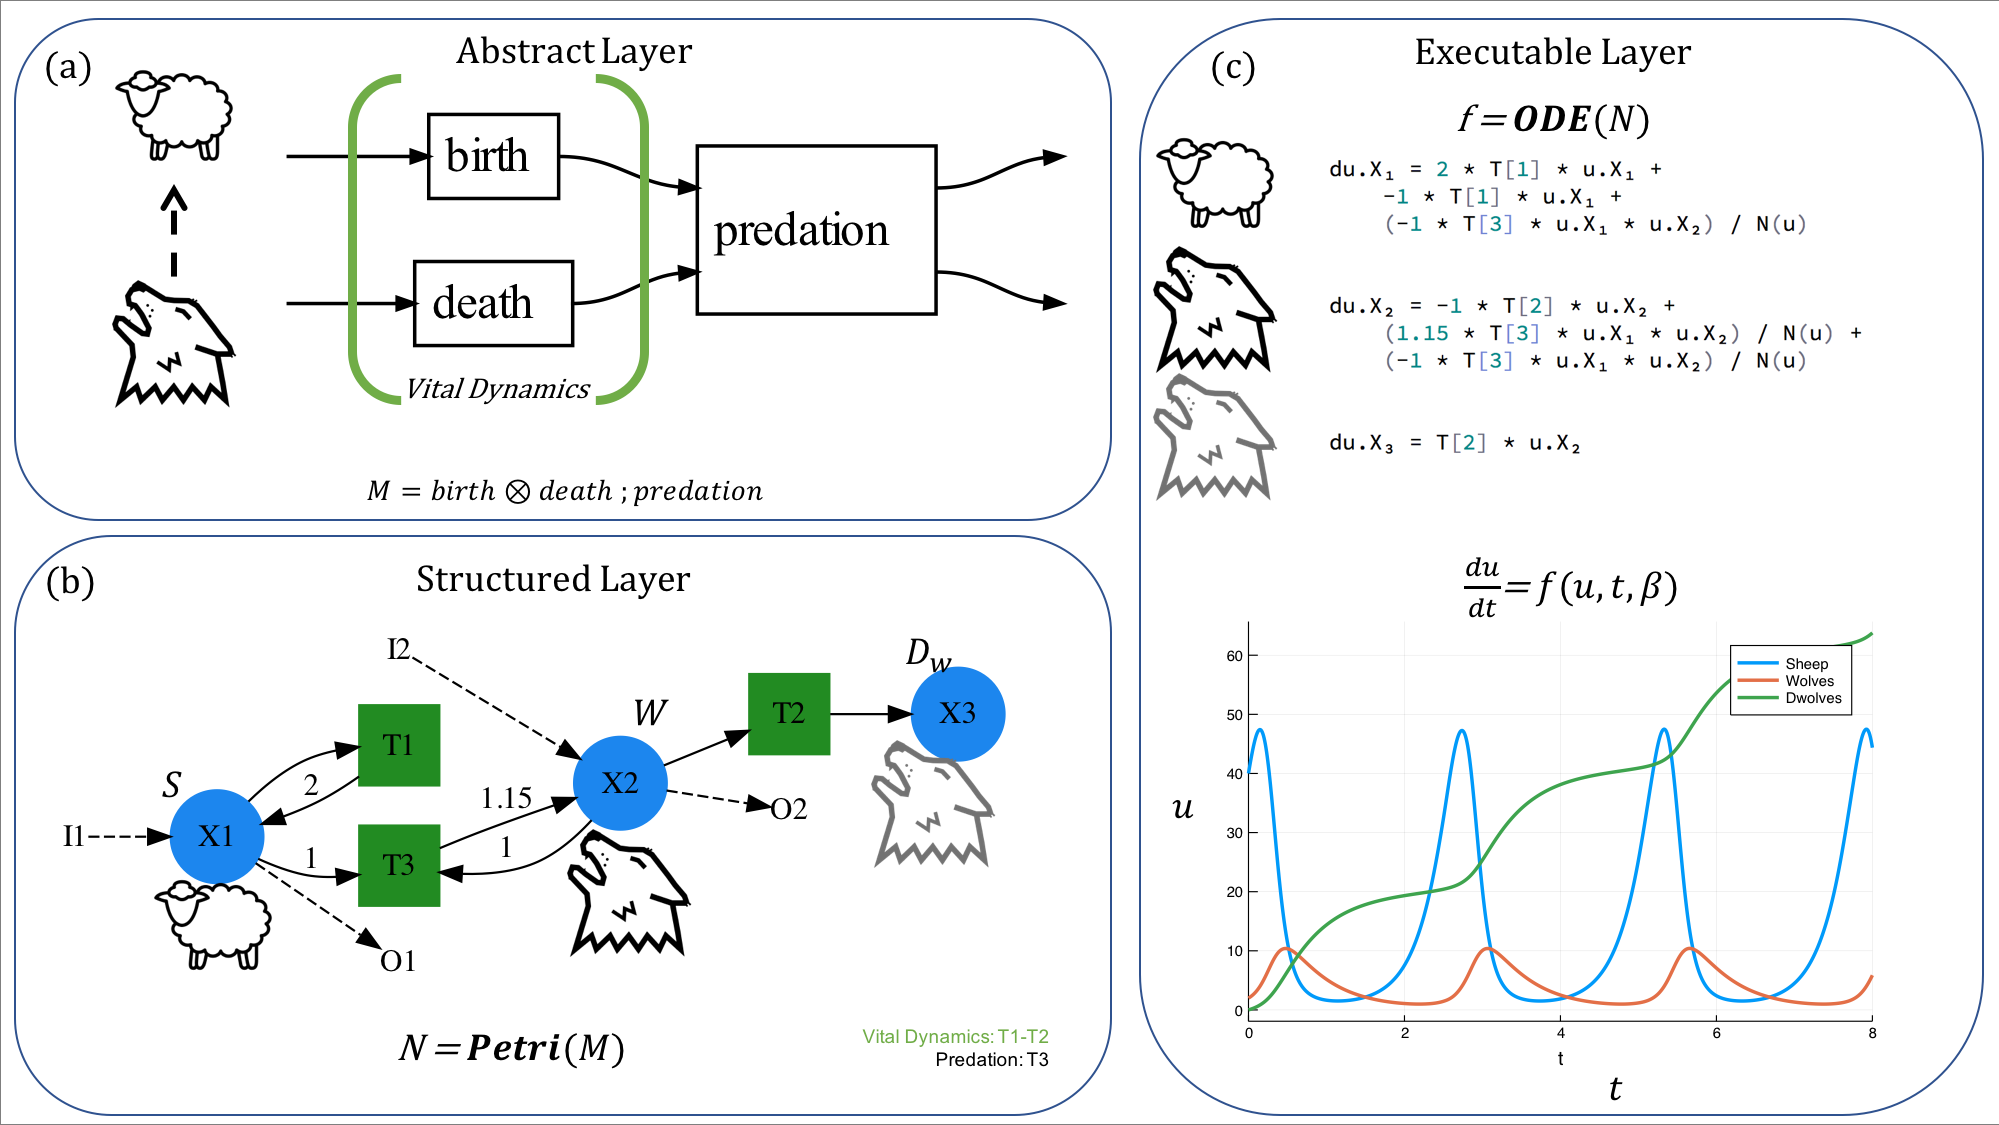


### Food Chain

The first predator is the second prey



bipredation is (p⊗I)⋅(I⊗p)

foodchain is (bipredation)⋅(bdd). A fish, a bigger fish, and biggest fish
Cannonical form construction proves:  compose(otimes(predation,id(X)),otimes(id(X),predation),otimes(birth,death,death)) == compose(otimes(predation,id(X)),otimes(id(X),predation),otimes(birth,death,death))


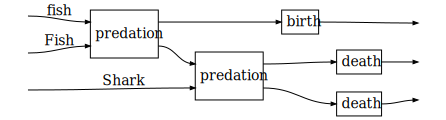

In [47]:
bdd = bd⊗d
bdb = b⊗(d⊗b)
println("bipredation is (p⊗I)⋅(I⊗p)")
bipredation = compose(p(1,1,2)⊗eye(1), eye(1)⊗p(1,1,2))
println("\nfoodchain is (bipredation)⋅(bdd). A fish, a bigger fish, and biggest fish")
foodchainh = compose(ph⊗idₓ, idₓ⊗ph, bh⊗dh⊗dh)
homx = SemanticModels.ModelTools.WiringDiagrams.canonical(FreeSymmetricMonoidalCategory, foodchainh)
println("Cannonical form construction proves:  $foodchainh == $homx")
#drawhom(foodchainh, "img/foodchain_wd")
display(wd(foodchainh), [:fish, :Fish, :Shark])

Domain: [1, 2, 3]
Codomain: [1, 2, 3]
Model: Model(S=[1, 2, 3, 4, 5], Δ=[1 * X₁() + 1 * X₂()→1.15 * X₂(), 1 * X₂() + 1 * X₃()→1.15 * X₃(), X₁()→2 * X₁(), X₂()→X₄(), X₃()→X₅()])


M = PetriModel(Model(∣S∣=5,∣Δ∣=5))
f′ = OpenModel:3→3 with PetriModel(Model(∣S∣=5,∣Δ∣=5))


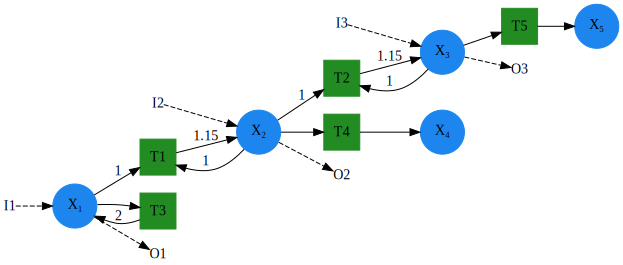

In [48]:
foodchain = compile(foodchainh)
display(foodchain)

In [49]:
println("As an ordinary differential equation:")
odeexpr(foodchain).args[end].args[end].args[end]

As an ordinary differential equation:


quote
    du.X₁ = (-1 * T[1] * u.X₁ * u.X₂) / N(u) + 2 * T[3] * u.X₁ + -1 * T[3] * u.X₁
    du.X₃ = (1.15 * T[2] * u.X₂ * u.X₃) / N(u) + (-1 * T[2] * u.X₂ * u.X₃) / N(u) + -1 * T[5] * u.X₃
    du.X₄ = T[4] * u.X₂
    du.X₂ = (1.15 * T[1] * u.X₁ * u.X₂) / N(u) + (-1 * T[1] * u.X₁ * u.X₂) / N(u) + (-1 * T[2] * u.X₂ * u.X₃) / N(u) + -1 * T[4] * u.X₂
    du.X₅ = T[5] * u.X₃
end


### Food Star

The first predator is the second predator (with two independent prey species)



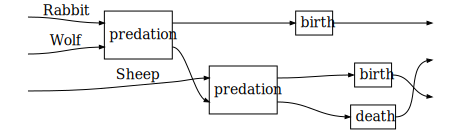

In [50]:
foodstarh = compose(ph⊗idₓ, idₓ⊗compose(σh,ph, σh), bh⊗dh⊗bh)
display(wd(foodstarh), [:Rabbit, :Wolf, :Sheep])

OpenModel:3→3 with PetriModel(Model(∣S∣=4,∣Δ∣=5))
Cannonical form construction proves:  compose(otimes(predation,id(X)),otimes(id(X),compose(braid(X,X),predation,braid(X,X))),otimes(birth,death,birth)) == compose(otimes(predation,id(X)),otimes(id(X),braid(X,X)),otimes(id(X),predation),otimes(id(X),braid(X,X)),otimes(birth,death,birth))
As an ordinary differential equation:
odeexpr(foodstar) = quote
    ##state#380(du, u, T, t) = begin
            begin
                du.X₁ = (-1 * T[1] * u.X₁ * u.X₂) / N(u) + 2 * T[3] * u.X₁ + -1 * T[3] * u.X₁
                du.X₃ = (-1 * T[2] * u.X₃ * u.X₂) / N(u) + 2 * T[5] * u.X₃ + -1 * T[5] * u.X₃
                du.X₄ = T[4] * u.X₂
                du.X₂ = (1.15 * T[1] * u.X₁ * u.X₂) / N(u) + (-1 * T[1] * u.X₁ * u.X₂) / N(u) + (1.15 * T[2] * u.X₃ * u.X₂) / N(u) + (-1 * T[2] * u.X₃ * u.X₂) / N(u) + -1 * T[4] * u.X₂
            end
        end
end
Domain: [1, 2, 3]
Codomain: [1, 2, 3]
Model: Model(S=[1, 2, 3, 4], Δ=[1 * X₁() + 1 * X₂()→1.15 * X₂(),

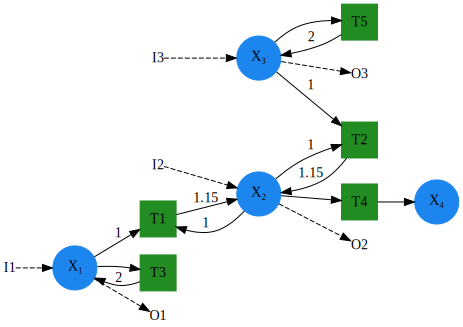

In [51]:
foodstar = compile(foodstarh) 
println(foodstar)

homx = canonical(FreeSymmetricMonoidalCategory, foodstarh)
println("Cannonical form construction proves:  $foodstarh == $homx")
println("As an ordinary differential equation:")
@show odeexpr(foodstar)
display(foodstar)

## Malaria




In [52]:
dualinfect = compose(ph⊗idₓ, idₓ⊗pdagh)
cur = Hom(:cure, Xob⊗Xob, Xob⊗Xob)
curdag = Hom(Symbol("cur⋆"), Xob^2, Xob^2)
inf = Hom(Symbol("inf¹³₂₃"), Xob^3, Xob^3)

#inf′ = Hom(Symbol("inf³¹₂₁"), Xob^3, Xob^3)
#malariah = compose(inf⊗idₓ, idₓ⊗compose(compose(σh⊗idₓ, idₓ⊗σh), inf, compose(idₓ⊗idₓ⊗idₓ, idₓ⊗σh, σh⊗idₓ)),cur⊗conj(cur, σh))
malariah = compose(inf⊗idₓ, idₓ⊗compose(σh⊗idₓ, idₓ⊗σh, σh⊗idₓ), idₓ⊗inf, idₓ⊗conj(σh⊗idₓ, idₓ⊗σh), cur⊗compose(σh, cur, σh))
#drawhom(malariah, "img/malaria_wd")

compose(otimes(inf¹³₂₃,id(X)),otimes(id(X),compose(otimes(braid(X,X),id(X)),otimes(id(X),braid(X,X)),otimes(braid(X,X),id(X)))),otimes(id(X),inf¹³₂₃),otimes(id(X),compose(otimes(id(X),braid(X,X)),otimes(braid(X,X),id(X)),otimes(id(X),braid(X,X)))),otimes(cure,compose(braid(X,X),cure,braid(X,X))))

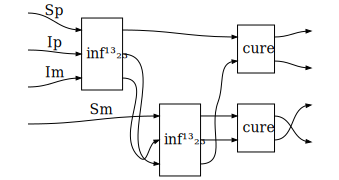

In [53]:
display(wd(malariah), ["Sp", "Ip", "Im", "Sm"])

Domain: [1, 2]
Codomain: [1, 2]
Model: Model(S=[1, 2], Δ=[X₂()→X₁(), X₂()→X₁()])


M = PetriModel(Model(∣S∣=2,∣Δ∣=1))
f′ = OpenModel:2→2 with PetriModel(Model(∣S∣=2,∣Δ∣=1))


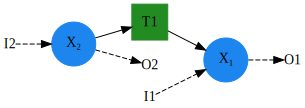

In [54]:
cure = conj(spontaneous, σ())
display(cure)

In [55]:
curedag = op(cure.model.model)
curedag == spontaneous.model.model

true

In order to build the mosquito borne illness model, we need a new primative. In this case $X_1 + X_3 \rightarrow X_2 + X_3$ 

Domain: [1, 2, 3]
Codomain: [1, 2, 3]
Model: Model(S=[1, 2, 3], Δ=[X₁() + X₃()→X₂() + X₃(), X₁() + X₃()→X₂() + X₃()])


M = PetriModel(Model(∣S∣=3,∣Δ∣=1))
f′ = OpenModel:3→3 with PetriModel(Model(∣S∣=3,∣Δ∣=1))


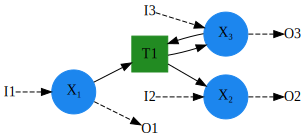

In [56]:
trinary  = OpenModel([1,2,3], model(PetriModel, Model([1,2,3], [(X[1]+X[3], X[2]+X[3])])), [1,2,3])
set_primitive(inf, trinary)
display(trinary)

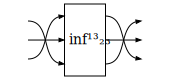

In [57]:
inf′ = compose(σh⊗idₓ, idₓ⊗σh, σh⊗idₓ, inf, conj(σh⊗idₓ, idₓ⊗σh))
display(wd(inf′))

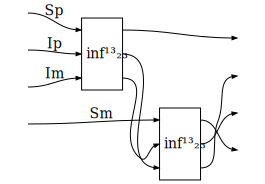

In [58]:
dualinfecth = compose(inf⊗idₓ, idₓ⊗inf′)
display(wd(dualinfecth), ["Sp", "Ip","Im","Sm"])

Domain: [1, 2, 3, 4]
Codomain: [1, 2, 3, 4]
Model: Model(S=[1, 2, 3, 4], Δ=[X₁() + X₃()→X₂() + X₃(), X₄() + X₂()→X₃() + X₂()])


M = PetriModel(Model(∣S∣=4,∣Δ∣=2))
f′ = OpenModel:4→4 with PetriModel(Model(∣S∣=4,∣Δ∣=2))


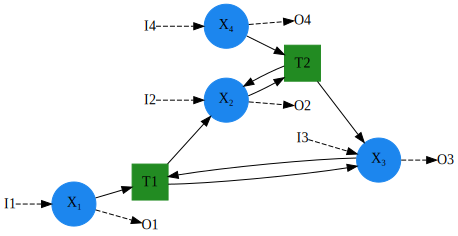

In [59]:
dualinfect = compile(dualinfecth)
display(dualinfect)

Cannonical form construction proves:
	  compose(otimes(inf¹³₂₃,id(X)),otimes(id(X),compose(otimes(braid(X,X),id(X)),otimes(id(X),braid(X,X)),otimes(braid(X,X),id(X)))),otimes(id(X),inf¹³₂₃),otimes(id(X),compose(otimes(id(X),braid(X,X)),otimes(braid(X,X),id(X)),otimes(id(X),braid(X,X)))),otimes(cure,compose(braid(X,X),cure,braid(X,X)))) 
	== 
	  compose(otimes(inf¹³₂₃,id(X)),otimes(id(X),braid(X,X),id(X)),otimes(id(otimes(X,X)),braid(X,X)),otimes(id(X),braid(X,X),id(X)),otimes(id(X),inf¹³₂₃),otimes(id(otimes(X,X)),braid(X,X)),otimes(id(X),braid(X,X),id(X)),otimes(cure,cure),otimes(id(otimes(X,X)),braid(X,X)))
As an ordinary differential equation:
odeexpr(malaria) = quote
    ##state#381(du, u, T, t) = begin
            begin
                du.X₁ = (-1 * T[1] * u.X₁ * u.X₃) / N(u) + T[3] * u.X₂
                du.X₃ = (T[1] * u.X₁ * u.X₃) / N(u) + (-1 * T[1] * u.X₁ * u.X₃) / N(u) + (T[2] * u.X₄ * u.X₂) / N(u) + -1 * T[4] * u.X₃
                du.X₄ = (-1 * T[2] * u.X₄ * u.X₂) / N(u) + 

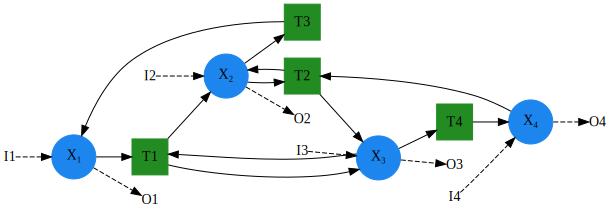

In [60]:
set_primitive(ph, p(1,1,1.15))
set_primitive(cur, cure)
set_primitive(inf, trinary)
#lookuptable = Dict(bh=>b, dh=>d, σh=>σ(), ph=>p(1,1,1.15), inf=>trinary,idₓ=>eye(1), cur=>cure)
malaria = compile(malariah)
homx = canonical(FreeSymmetricMonoidalCategory, malariah)
println("Cannonical form construction proves:\n\t  $malariah \n\t== \n\t  $homx")
println("As an ordinary differential equation:")
@show odeexpr(malaria)
debug_show(malaria, "img/malaria.svg")

In [61]:
f = Petri.mk_function(malaria.model.model)

#65 (generic function with 1 method)

In [62]:
u0 = @LArray [20,1,0,100.0] (:X₁, :X₂, :X₃, :X₄)
varnames = ["\$S_p\$", "\$I_p\$", "\$I_m\$", "\$S_m\$"];

## Endemic Malaria
Because we assumed that Malaria is SIS for both People and Mosquitos the only solution is endemic malaria, where there is a constant fraction of infected people at equilibrium.

sol[end] = 4-element LArray{Float64,1,Array{Float64,1},(:X₁, :X₂, :X₃, :X₄)}:
 :X₁ => 15.732701193912227
 :X₂ => 5.267298806087765 
 :X₃ => 37.20917844060933 
 :X₄ => 62.79082155939067 


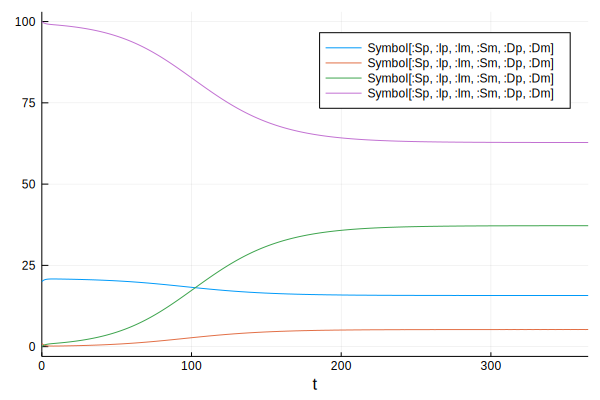

In [63]:
βpm = 0.0045
βmp = 0.0045
ρp = 0.5
ρm = 0.04
νp = 0.006

νm = 0.1

params = [βpm, βmp,ρp,ρm]
prob = ODEProblem(f,u0,(0.0,365.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]

varnames = [:Sp, :Ip, :Im, :Sm, :Dp, :Dm]

plt = plot(sol, vars =1:length(varnames)-2, labels=varnames)

savefig(plt, "img/malaria_sol_endemic.png")
plt

# Malaria Driven Extinction

In the case where malaria is fatal to some fraction of the population and you start off with more mosquitos than people:

    Blessed are the mosquitos, for they shall inherit the earth

In [64]:
malvitalh = compose(malariah, bh⊗dh⊗dh⊗bh)

compose(otimes(inf¹³₂₃,id(X)),otimes(id(X),compose(otimes(braid(X,X),id(X)),otimes(id(X),braid(X,X)),otimes(braid(X,X),id(X)))),otimes(id(X),inf¹³₂₃),otimes(id(X),compose(otimes(id(X),braid(X,X)),otimes(braid(X,X),id(X)),otimes(id(X),braid(X,X)))),otimes(cure,compose(braid(X,X),cure,braid(X,X))),otimes(birth,death,death,birth))

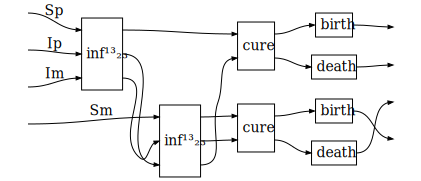

In [65]:
display(wd(malvitalh), ["Sp", "Ip","Im","Sm"])

Domain: [1, 2, 3, 4]
Codomain: [1, 2, 3, 4]
Model: Model(S=[1, 2, 3, 4, 5, 6], Δ=[X₁() + X₃()→X₂() + X₃(), X₄() + X₂()→X₃() + X₂(), X₂()→X₁(), X₃()→X₄(), X₁()→2 * X₁(), X₂()→X₅(), X₃()→X₆(), X₄()→2 * X₄()])


M = PetriModel(Model(∣S∣=6,∣Δ∣=8))
f′ = OpenModel:4→4 with PetriModel(Model(∣S∣=6,∣Δ∣=8))


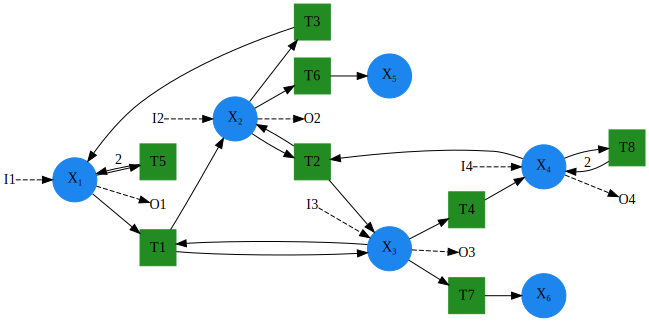

In [66]:
malvital = compile(malvitalh); #compose(malaria, b⊗d⊗d⊗b)
display(malvital)

In [67]:
println("As an ordinary differential equation:")
@show fex = odeexpr(malvital)
f = Petri.mk_function(malvital.model.model)

As an ordinary differential equation:
fex = odeexpr(malvital) = quote
    ##state#388(du, u, T, t) = begin
            begin
                du.X₁ = (-1 * T[1] * u.X₁ * u.X₃) / N(u) + T[3] * u.X₂ + 2 * T[5] * u.X₁ + -1 * T[5] * u.X₁
                du.X₆ = T[7] * u.X₃
                du.X₃ = (T[1] * u.X₁ * u.X₃) / N(u) + (-1 * T[1] * u.X₁ * u.X₃) / N(u) + (T[2] * u.X₄ * u.X₂) / N(u) + -1 * T[4] * u.X₃ + -1 * T[7] * u.X₃
                du.X₄ = (-1 * T[2] * u.X₄ * u.X₂) / N(u) + T[4] * u.X₃ + 2 * T[8] * u.X₄ + -1 * T[8] * u.X₄
                du.X₂ = (T[1] * u.X₁ * u.X₃) / N(u) + (T[2] * u.X₄ * u.X₂) / N(u) + (-1 * T[2] * u.X₄ * u.X₂) / N(u) + -1 * T[3] * u.X₂ + -1 * T[6] * u.X₂
                du.X₅ = T[6] * u.X₂
            end
        end
end


#65 (generic function with 1 method)

In [68]:
u0 = @LArray [20,1,0,100,0.1,0] (:X₁, :X₂, :X₃, :X₄, :X₅, :X₆)
varnames = ["\$S_p\$", "\$I_p\$", "\$I_m\$", "\$S_m\$", "\$Dp\$", "\$Dm\$"];

sol[end] = 6-element LArray{Float64,1,Array{Float64,1},(:X₁, :X₂, :X₃, :X₄, :X₅, :X₆)}:
 :X₁ => 0.11867282087028246
 :X₂ => 0.6300807393074943 
 :X₃ => 15.665982122469652 
 :X₄ => 115.38905948922113 
 :X₅ => 25.77302641076068  
 :X₆ => 152.68431308161598 


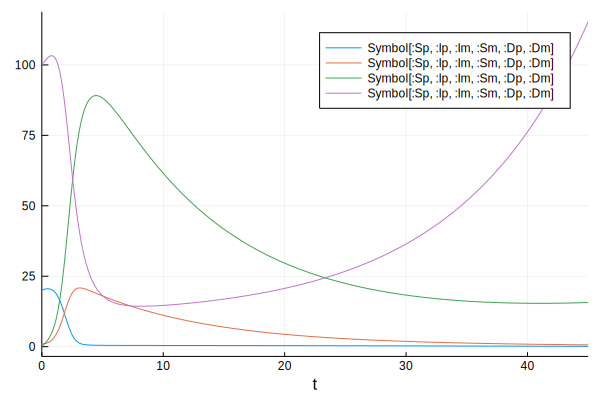

In [69]:
βpm = 0.045
βmp = 0.045
ρp = 0.1
ρm = 0.1
νp = 0.1
δp = 0.1
δm = 0.1
νm = 0.1

params = [βpm, βmp,ρp,ρm, νp, δp, δm, νm]
prob = ODEProblem(f,u0,(0.0,45.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]

varnames = [:Sp, :Ip, :Im, :Sm, :Dp, :Dm]

plt = plot(sol, vars =1:length(varnames)-2, labels=varnames)
# ylims!(plt, (0,100))
# xlims!(plt, (0,50))
# yaxis!("amount", :log10)
savefig(plt, "img/malaria_sol_fatal.png")
plt

## Endemic Malaria with Vital dynamics


In [70]:
u0 = @LArray [20,1,0,100,0.1,0] (:X₁, :X₂, :X₃, :X₄, :X₅, :X₆)
varnames = ["\$S_p\$", "\$I_p\$", "\$I_m\$", "\$S_m\$", "\$Dp\$", "\$Dm\$"];

sol[end] = 6-element LArray{Float64,1,Array{Float64,1},(:X₁, :X₂, :X₃, :X₄, :X₅, :X₆)}:
 :X₁ => 7.925127524566165 
 :X₂ => 63.53298833788486 
 :X₃ => 116.96980123637196
 :X₄ => 24.60103386317961 
 :X₅ => 495.33260892916763
 :X₆ => 345.1517255284083 


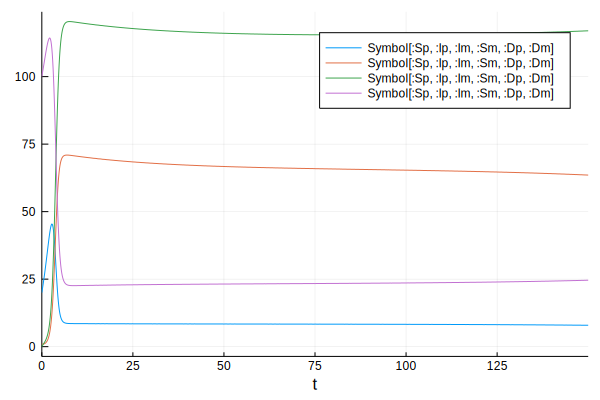

In [71]:
βpm = 0.024
βmp = 0.024
ρp = 0.3
ρm = 0.3
νp = 0.4
δp = 0.051
δm = 0.02025
νm = 0.1

params = [βpm, βmp,ρp,ρm, νp, δp, δm, νm]
prob = ODEProblem(f,u0,(0.0,150.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]

varnames = [:Sp, :Ip, :Im, :Sm, :Dp, :Dm]

plt = plot(sol, vars =1:length(varnames)-2, labels=varnames)
# ylims!(plt, (0,100))
# xlims!(plt, (0,50))
# yaxis!("amount", :log10)
savefig(plt, "img/malaria_sol_fatal.png")
plt

## Mosquito Hunting Birds

We want to perform cross domain model fusion, by incorporated ecology into our epidemiology. This means adding a species of birds that eat the mosquitos.



This gives rise to the following high level model structure. Where `malaria, mutual predation,` and `vitals` are submodels 

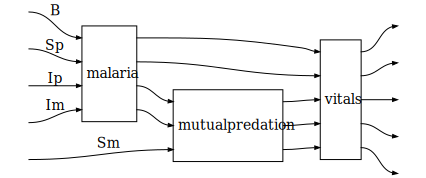

In [72]:
display(wd(compose(Hom(:malaria, Xob^4, Xob^4)⊗idₓ, idₓ^2⊗Hom(:mutualpredation, Xob^3, Xob^3), Hom(:vitals, Xob^5, Xob^5))), [:B, :Sp, :Ip, :Im, :Sm])

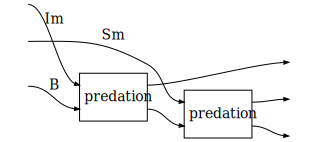

In [73]:
birdsh = compose(σh⊗idₓ,idₓ⊗ph, σh⊗idₓ, idₓ⊗ph)
display(wd(birdsh), [:Im, :B, :Sm])

Cannonical form construction proves:  compose(otimes(braid(X,X),id(X)),otimes(id(X),predation),otimes(braid(X,X),id(X)),otimes(id(X),predation)) == compose(otimes(id(X),braid(X,X)),otimes(predation,id(X)),otimes(id(X),braid(X,X)),otimes(id(X),predation))


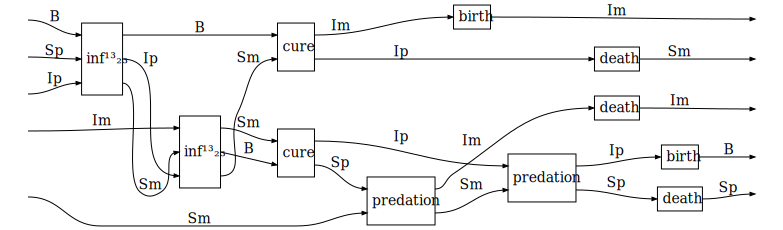

In [74]:
drawhom(birdsh, "img/birds_wd")
homx = canonical(FreeSymmetricMonoidalCategory, birdsh)
println("Cannonical form construction proves:  $birdsh == $homx")
# vitals for Sp, Ip, Im, Sm, B are:
# born, die (of malaria), die (of malaria), born, die (starvation)
vitalsh = bh⊗dh⊗dh⊗bh⊗dh
#birdmalh = compose(malvitalh⊗idₓ, idₓ^2⊗compose(birdsh, idₓ^2⊗dh))
birdmalh = compose(malariah⊗ idₓ, idₓ^2⊗birdsh, vitalsh)
drawhom(birdmalh, "img/birdmal_wd")
display(wd(birdmalh), [:B, :Sp, :Ip, :Im, :Sm, :Sm, :Ip,:B,:Sm,:Sm, :B,:Im,:Ip, :Sp,:Ip,:Sm,:Im, :Ip,:Sp,:Im,:Sm,:Im, :B, :Sp])

In [75]:
birds = compose(σ()⊗eye(1), eye(1)⊗p(1,1,1.15), σ()⊗eye(1), eye(1)⊗p(1,1,1.15))
debug_show(birds, "img/birds.svg")
birdmal = compile(birdmalh)
debug_show(birdmal, "img/birdmal.svg");

Domain: [1, 2, 3]
Codomain: [1, 2, 3]
Model: Model(S=[1, 2, 3], Δ=[1 * X₁() + 1 * X₃()→1.15 * X₃(), 1 * X₂() + 1 * X₃()→1.15 * X₃()])


M = PetriModel(Model(∣S∣=3,∣Δ∣=2))
f′ = OpenModel:3→3 with PetriModel(Model(∣S∣=3,∣Δ∣=2))
Domain: [1, 2, 3, 4, 5]
Codomain: [1, 2, 3, 4, 5]
Model: Model(S=[1, 2, 3, 4, 5, 6, 7, 8], Δ=[X₁() + X₃()→X₂() + X₃(), X₄() + X₂()→X₃() + X₂(), X₂()→X₁(), X₃()→X₄(), 1 * X₃() + 1 * X₅()→1.15 * X₅(), 1 * X₄() + 1 * X₅()→1.15 * X₅(), X₁()→2 * X₁(), X₂()→X₆(), X₃()→X₇(), X₄()→2 * X₄(), X₅()→X₈()])


M = PetriModel(Model(∣S∣=8,∣Δ∣=11))
f′ = OpenModel:5→5 with PetriModel(Model(∣S∣=8,∣Δ∣=11))


The coupled model of Malaria and Predation: 

![The coupled model of Malaria](./img/malaria_labeled.png)

In [76]:
println("As an ordinary differential equation:")
fex = @show odeexpr(birdmal)
Petri.N(s) = 1 #sum(s[1:end-3])
f = Petri.mk_function(birdmal.model.model)

As an ordinary differential equation:
odeexpr(birdmal) = quote
    ##state#396(du, u, T, t) = begin
            begin
                du.X₁ = (-1 * T[1] * u.X₁ * u.X₃) / N(u) + T[3] * u.X₂ + 2 * T[7] * u.X₁ + -1 * T[7] * u.X₁
                du.X₇ = T[9] * u.X₃
                du.X₆ = T[8] * u.X₂
                du.X₃ = (T[1] * u.X₁ * u.X₃) / N(u) + (-1 * T[1] * u.X₁ * u.X₃) / N(u) + (T[2] * u.X₄ * u.X₂) / N(u) + -1 * T[4] * u.X₃ + (-1 * T[5] * u.X₃ * u.X₅) / N(u) + -1 * T[9] * u.X₃
                du.X₄ = (-1 * T[2] * u.X₄ * u.X₂) / N(u) + T[4] * u.X₃ + (-1 * T[6] * u.X₄ * u.X₅) / N(u) + 2 * T[10] * u.X₄ + -1 * T[10] * u.X₄
                du.X₈ = T[11] * u.X₅
                du.X₂ = (T[1] * u.X₁ * u.X₃) / N(u) + (T[2] * u.X₄ * u.X₂) / N(u) + (-1 * T[2] * u.X₄ * u.X₂) / N(u) + -1 * T[3] * u.X₂ + -1 * T[8] * u.X₂
                du.X₅ = (1.15 * T[5] * u.X₃ * u.X₅) / N(u) + (-1 * T[5] * u.X₃ * u.X₅) / N(u) + (1.15 * T[6] * u.X₄ * u.X₅) / N(u) + (-1 * T[6] * u.X₄ * u.X₅) / N(u) + -1 * T[

#65 (generic function with 1 method)

In [77]:
u0 = @LArray [20,1,0,100,0.2,0,0,0.0] (:X₁, :X₂, :X₃, :X₄, :X₅, :X₆, :X₇, :X₈)
varnames = ["\$S_p\$", "\$I_p\$", "\$I_m\$", "\$S_m\$", "\$B\$", "\$Dp\$", "\$Dm\$", "\$D_b\$"];

## Malaria Driven Extinction

In the following setting everyone dies, but then the mosquito population becomes locked in a Lotka-Volterra struggle for the earth.

sol[end] = 8-element LArray{Float64,1,Array{Float64,1},(:X₁, :X₂, :X₃, :X₄, :X₅, :X₆, :X₇, :X₈)}:
 :X₁ => 0.6518805080603127   
 :X₂ => 3.941103979695824e-10
 :X₃ => 1.9924704894790895e-8
 :X₄ => 56.27588404587209    
 :X₅ => 0.001128052681505196 
 :X₆ => 21.23354568888048    
 :X₇ => 4.831252578944915    
 :X₈ => 112.68596179894249   


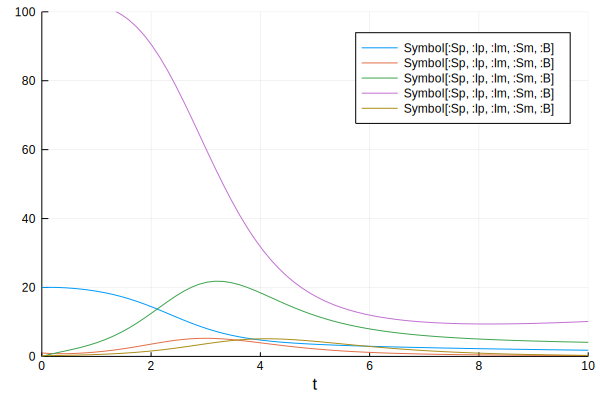

In [78]:
βpm = 0.045
βmp = 0.045
ρp = 0.5
ρm = 0.04
ηI = 0.12
ηS = 0.12
νp = 0.006
δp = 1.0
δm = 0.03
νm = 0.1
δb = 0.85
params = [βpm, βmp,ρp,ρm,ηI, ηS, νp, δp, δm, νm, δb]
prob = ODEProblem(f,u0,(0.0, 160.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]

varnames = [:Sp, :Ip, :Im, :Sm, :B, :Dp, :Dm,:Db]
plotvars = [1,2,3,4,5]
plt = plot(sol, vars =plotvars, labels=varnames[plotvars])
ylims!(plt, (0,100))
xlims!(plt, (0,10))
# yaxis!("amount", :log10)
savefig(plt, "img/birdmal_sol_subcritical.png")
plt

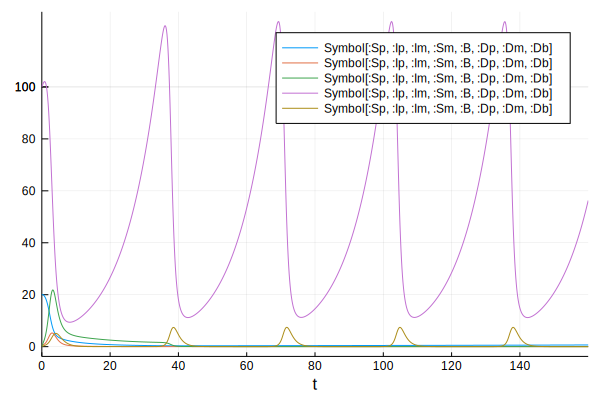

In [79]:
plt = plot(sol, vars =1:length(varnames)-3, labels=varnames)
#yaxis!(plt, (0,30))

## Endemic Malaria

In the following example, malaria is endemic and cyclical within a population. After a phase of initially wild fluctuation, we settle down into a rythm of cyclic epidemics. The exponential growth and decay cycles are driven by the Lotka Volterra dynamics between the birds and the mosquitos.

sol[end] = 8-element LArray{Float64,1,Array{Float64,1},(:X₁, :X₂, :X₃, :X₄, :X₅, :X₆, :X₇, :X₈)}:
 :X₁ => 7.712559228639179 
 :X₂ => 0.6319676256180915
 :X₃ => 4.833412874122064 
 :X₄ => 106.28886193362646
 :X₅ => 22.715481343531284
 :X₆ => 5139.821732857274 
 :X₇ => 288.4689513634201 
 :X₈ => 2948.9339969383295


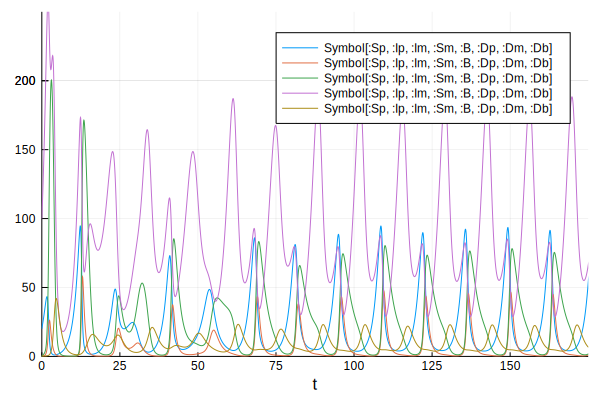

In [80]:
βpm = 0.045
βmp = 0.045
ρp = 1.2
ρm = 0.4
ηI = 0.05
ηS = 0.05
νp = 0.600
δp = 1.9
δm = 0.03
νm = 0.6
δb = 0.85
params = [βpm, βmp,ρp,ρm,ηI, ηS, νp, δp, δm, νm, δb]
prob = ODEProblem(f,u0,(0.0,375.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]

plt = plot(sol, vars =1:length(varnames)-3, labels=varnames)
ylims!(plt, (0,250))
xlims!(plt, (0,175))
savefig(plt, "img/birdmal_sol_multiepi.pdf")
plt

Zooming in on a cycle you can see that the mosquitos and birds interact with a mixture of Lotka Volterra dynamics and SIS dynamics. The population of birds tracks the population of mosquitos, as the number of birds increases, they drive mosquitos to near extinction. Once there are no birds to eat the mosquitos, the population of mosquitos explodes. At this point the human population has rebounded and is decimated by an epdidemic of malaria. The epidemic ends when the number of human hosts is small enough to all for recovery of the infected mosquitos. Recall that we assumed that Malaria is (SISD) in both people and mosquitos.

You can see from the zoomed in plot that the malaria outbreaks occur approximately half a cycle shifted from the Lotka Volterra cycle in the mosquito population.

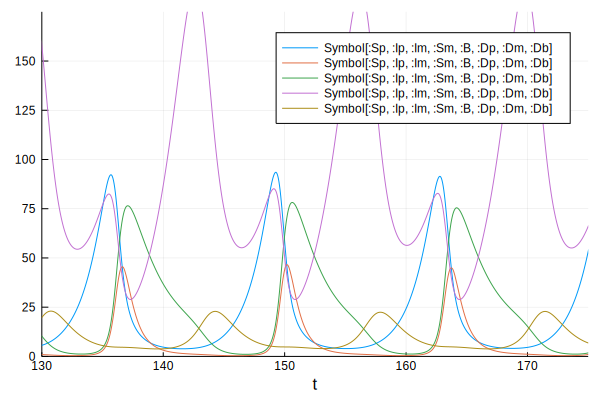

In [81]:
plt = plot(sol, vars =1:length(varnames)-3, labels=varnames)
ylims!(plt, (0,175))
xlims!(plt, (130,175))
savefig(plt, "img/birdmal_sol_multiepi_zoom.pdf")
plt

We can even generate the same model as a stochastic simulation. Allow you to describe the model in a declarative high level language and then compile multiple implementations of that model depending on the scientific question at the time. 

In [85]:
striplines.(Petri.Δ(birdmal.model.model, :u))

MacroTools.striplines(q) = quote
    begin
        u.X₁ > 0 || return nothing
        u.X₃ > 0 || return nothing
        u.X₁ -= 1
        u.X₃ -= 1
    end
    begin
        u.X₂ += 1
        u.X₃ += 1
    end
end
MacroTools.striplines(q) = quote
    begin
        u.X₄ > 0 || return nothing
        u.X₂ > 0 || return nothing
        u.X₄ -= 1
        u.X₂ -= 1
    end
    begin
        u.X₃ += 1
        u.X₂ += 1
    end
end
MacroTools.striplines(q) = quote
    begin
        u.X₂ > 0 || return nothing
        u.X₂ -= 1
    end
    u.X₁ += 1
end
MacroTools.striplines(q) = quote
    begin
        u.X₃ > 0 || return nothing
        u.X₃ -= 1
    end
    u.X₄ += 1
end
MacroTools.striplines(q) = quote
    begin
        u.X₃ > 0 || return nothing
        u.X₅ > 0 || return nothing
        u.X₃ -= 1
        u.X₅ -= 1
    end
    u.X₅ += 1.15
end
MacroTools.striplines(q) = quote
    begin
        u.X₄ > 0 || return nothing
        u.X₅ > 0 || return nothing
        u.X₄ -= 1
        u.X₅ -= 1

11-element Array{Expr,1}:
 :(##δ#409(state) = begin
          begin
              begin
                  u.X₁ > 0 || return nothing
                  u.X₃ > 0 || return nothing
                  u.X₁ -= 1
                  u.X₃ -= 1
              end
              begin
                  u.X₂ += 1
                  u.X₃ += 1
              end
          end
      end)
 :(##δ#410(state) = begin
          begin
              begin
                  u.X₄ > 0 || return nothing
                  u.X₂ > 0 || return nothing
                  u.X₄ -= 1
                  u.X₂ -= 1
              end
              begin
                  u.X₃ += 1
                  u.X₂ += 1
              end
          end
      end)
 :(##δ#411(state) = begin
          begin
              begin
                  u.X₂ > 0 || return nothing
                  u.X₂ -= 1
              end
              u.X₁ += 1
          end
      end)                                                                                   

# Conclusion

1. SemanticModels.jl represents models at multiple Knowledge Representation Layers.
2. Composition and Combination are easiest at the Abstract Layer
3. Structured Layer contains a rigorous mathematical specification of the model
4. Executable Layer artifacts can be compiled from Structured Layer and exectued to solve complex models
5. Partially Symbolic Computing + Code Generation $\implies$ A revolution in Scientific Computing!
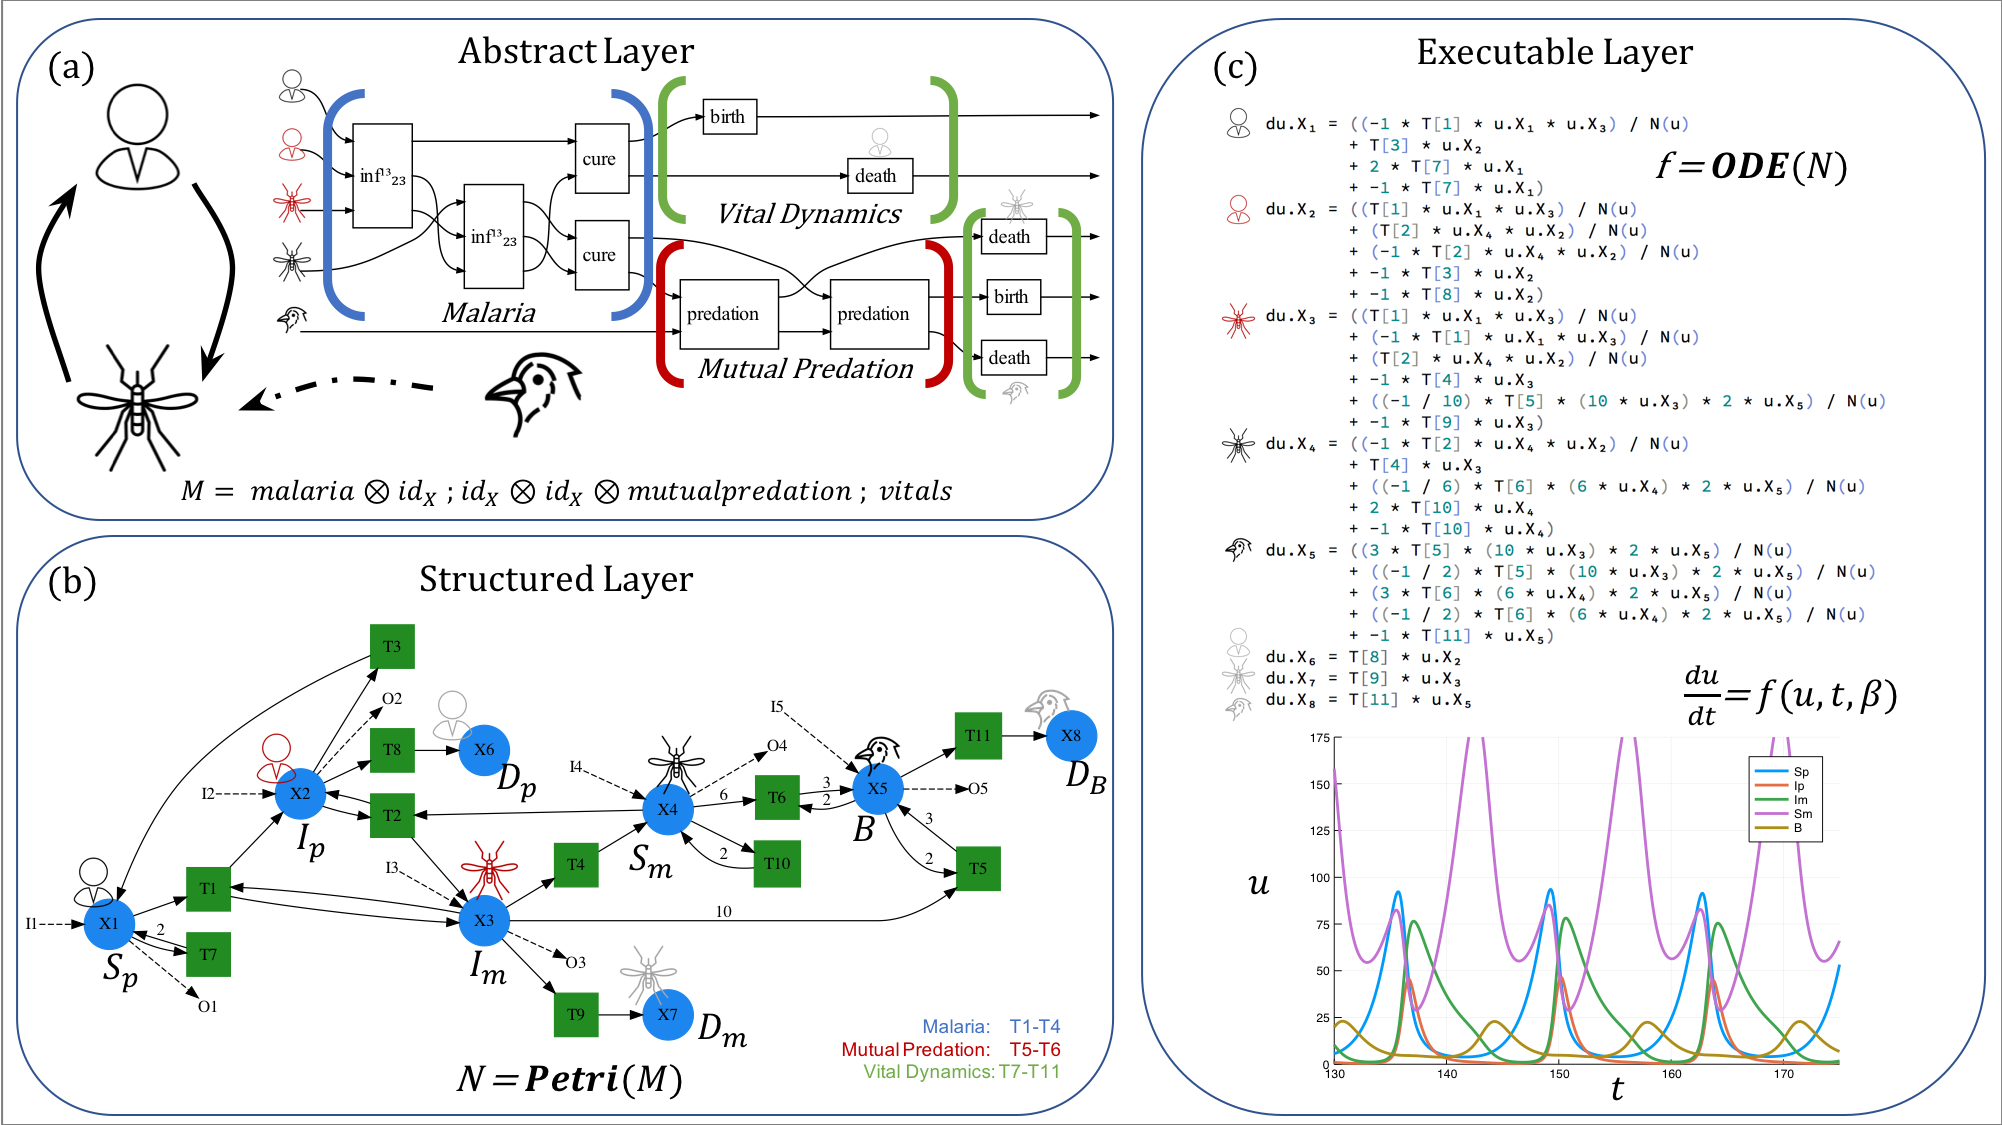

## Future Work

1. Generalize from Petri Nets to Graphs, DAGs, Relational Ologs, Schemas
2. Prove stuff
3. Functional programs as a fallback for code that has dynamics at the structured layer.

## Unstable System

The following choice of parameters exhibits an unstable dynamics, without approaching a periodic equilibrium.

sol[end] = 8-element LArray{Float64,1,Array{Float64,1},(:X₁, :X₂, :X₃, :X₄, :X₅, :X₆, :X₇, :X₈)}:
 :X₁ => 11.123154413593346
 :X₂ => 0.5143807897441445
 :X₃ => 0.8427577742796016
 :X₄ => 22.263659864659864
 :X₅ => 3.519623672723902 
 :X₆ => 354.2105605195812 
 :X₇ => 20.2908909296824  
 :X₈ => 353.48956919108684


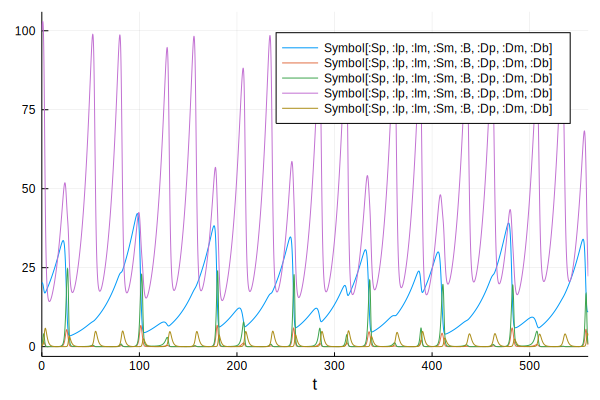

In [83]:
βpm = 0.045
βmp = 0.045
ρp = 0.5
ρm = 0.05
ηI = 0.6
ηS = 0.12
νp = 0.04
δp = 1.9
δm = 0.03
νm = 0.1
δb = 0.85
params = [βpm, βmp,ρp,ρm,ηI, ηS, νp, δp, δm, νm, δb]
prob = ODEProblem(f,u0,(0.0,560.0),params)
sol = solve(prob,Tsit5(), tol=1e-5)
@show sol[end]

varnames = [:Sp, :Ip, :Im, :Sm, :B, :Dp, :Dm, :Db]

plt = plot(sol, vars =1:length(varnames)-3, labels=varnames)
#ylims!(plt, (0,90))
#xlims!(plt, (0,50))
# yaxis!("amount", :log10)
savefig(plt, "img/birdmal_sol_subcritical.png")
plt

The outbreaks exhibit irregular behavior

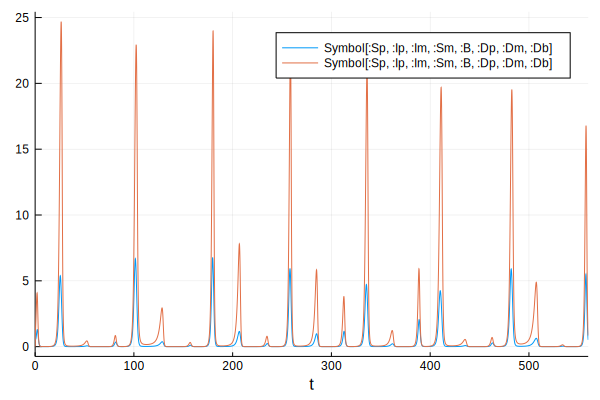

In [84]:
plt = plot(sol, vars =[2,3], labels=varnames)
#ylims!(plt, (0,10))
#xlims!(plt, (0,450))